In [1]:
import os
import pandas as pd
from helpers import inlib, eda, saved_models
from metrics import iv_woe, general_model_metrics

from sklearn.utils.class_weight import compute_sample_weight
from metrics import general_model_metrics
import xgboost as xgb

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

REFRESH_DATA = False
SHOW_TEST_ONLY = True

#### 0. Read the raw data and subset the file to fit memory. This step also takes care of:
1. Exclusions (policy rules)
2. Definition of the default flag
3. A few quick checks
4. Drop columns - for example recoveries (not available at the time of the default), dates, zip code, hardship period 
5. Subset 5% random stratified sample to fit in memory
6. Convert columns to the correct type - e.g. float/category/int etc.
7. Save the data to parquet to save space and load easily

In [2]:
if REFRESH_DATA:
    from read_data import df
elif os.path.exists(f'{inlib}/df.parquet'):
    df = pd.read_parquet(f'{inlib}/df.parquet')
    print('Data loaded from parquet file.')
    
else:
    print('Data not found. Run read_data.py to generate it.')

Data loaded from parquet file.


#### 1. Run a few descriptives and correlations to familiarize with the data

In [7]:
print('Descriptives statistics')
df.describe(include='all').style.background_gradient(axis = 0, cmap='coolwarm')

Descriptives statistics


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,title,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,orig_projected_additional_accrued_interest,disbursement_method,default_flag,late_31_120d,late_16_30d,grace_period
count,112895.000000,112895.000000,112895.000000,112895,112895.000000,112895.000000,112895,104538,105500,112895,112895.000000,112895,112895,112895,111655,112895,112806.000000,112895.000000,112895.000000,112895.000000,112895.000000,54883.000000,17787.000000,112895.000000,112895.000000,112895.000000,112807.000000,112895.000000,112895,112895.000000,112895.000000,112894.000000,28846.000000,112895,6104.000000,6104.000000,5840,112895.000000,109474.000000,109474.000000,69793.000000,69793.000000,69793.000000,69793.000000,67587.000000,69793.000000,59616.000000,69793.000000,69793.000000,69793.000000,69792.000000,109474.000000,69793.000000,69793.000000,69793.000000,110513.000000,109473.000000,109252.000000,109208.000000,112894.000000,112895.000000,106007.000000,109473.000000,109473.000000,109474.000000,110513.000000,109320.000000,25787.000000,98278.000000,36741.000000,109474.000000,109474.000000,109474.000000,110054.000000,109474.000000,109474.000000,109474.000000,109473.000000,109474.000000,110054.000000,105311.000000,109474.000000,109474.000000,109474.000000,109466.000000,109230.000000,112860.000000,112894.000000,109474.000000,110513.000000,110513.000000,109474.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5383.000000,5473.000000,5473.000000,5473.000000,5473.000000,1773.000000,424.000000,112895,112895.000000,112895.000000,112895.000000,112895.000000
unique,nan,nan,nan,2,nan,nan,35,45684,11,6,nan,3,2,14,4683,51,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2,nan,nan,nan,nan,2,nan,nan,3,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2,nan,nan,nan,nan
top,nan,nan,nan,36 months,nan,nan,C1,Teacher,10+ years,MORTGAGE,nan,Source Verified,n,debt_consolidation,Debt consolidation,CA,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,w,nan,nan,nan,nan,Individual,nan,nan,Not Verified,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan

In [4]:
print('Correlations in numeric fields')
correlations = df.select_dtypes(include='number').corr()
f = correlations.unstack().sort_values(ascending=False).drop_duplicates()
f = pd.DataFrame(f).reset_index().rename(columns={'level_0':'var1','level_1':'var2',0:'correlation'})
f.to_csv(f'{eda}/corr.csv')
correlations.style.background_gradient(cmap='coolwarm')

Correlations in numeric fields


#### 3. Further reduce the data from highly correlated fields. They have the ~ values. Drop the ones with lower information value

Some reliable metrics in binary classification models are the Weight of Evidence (WoE) and Information Value (IV)

In simple terms they measure the predictive power of an independent variable in relation to a dependent (binary) one. WoE = ln(% default / % performing). It can also be used to transform categorical/continuous variables. Generally speaking values > 0.5 are considered very high. Values < 0.02 are considered low.

In [5]:
correlations_ge_9 = f[abs(f['correlation']) > .9]
print(correlations_ge_9)

                         var1                 var2  correlation
0                 funded_amnt          funded_amnt     1.000000
1             fico_range_high       fico_range_low     1.000000
2                    open_acc             num_sats     0.998996
3             num_actv_rev_tl  num_rev_tl_bal_gt_0     0.983141
4                 tot_cur_bal      tot_hi_cred_lim     0.962410
5  total_il_high_credit_limit         total_bal_il     0.950027
6                 installment          funded_amnt     0.946133
7                total_bal_il    total_bal_ex_mort     0.906443


In [6]:
woe_cols = list(set(list(correlations_ge_9['var1'])+list(correlations_ge_9['var2']))) + ['default_flag']
woe_data = iv_woe(df[woe_cols], 'default_flag')

Information value of num_sats is 0.010802
Information value of tot_hi_cred_lim is 0.050908
Information value of fico_range_high is 0.162066
Information value of funded_amnt is 0.022506
Information value of total_il_high_credit_limit is 0.007335
Information value of tot_cur_bal is 0.043345
Information value of open_acc is 0.007067
Information value of num_actv_rev_tl is 0.031638
Information value of total_bal_il is 0.16673
Information value of installment is 0.026223
Information value of fico_range_low is 0.162066
Information value of num_rev_tl_bal_gt_0 is 0.031104
Information value of total_bal_ex_mort is 0.010804


Select highly correlated variables and drop to simplify the modelling data

In [7]:
df2 = df.drop(columns=['installment','last_fico_range_low', 'num_actv_rev_tl'])
df2.to_parquet(f'{inlib}/df2.parquet')

##### 4. Sample split
The sample of observations is randomly split 80/20 = train/test and is stratified by the depndent variable to achieve the same distribution of default/performing between train/test. In order to keep it simple and avoid extra cross-validationsteps the random state is not fixed during the experimental phase. All models are trained and tested on the same samples for each iteration.

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from helpers import inlib

df = pd.read_parquet(f'{inlib}/df2.parquet')

# Split the data into train and test
X = df.drop(columns=['default_flag'])

y = df['default_flag'].to_numpy('int8')
print(df['default_flag'].value_counts(dropna=False))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=100, stratify=y)
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

print(y_train.sum())
print(y_test.sum())
print(y_test.shape)

default_flag
0    99465
1    13430
Name: count, dtype: int64
X shape: (112895, 104)
y shape: (112895,)
10744
2686
(22579,)


#### 5. Modelling

Given the nature of the problem and the low dimensions of the data we could first try to run a simple classifier so we have gain undersanding and have a benchmark for performance. When it comes to implementation and maintenance it might not be worthed invest the effort in a more complex model architecture.

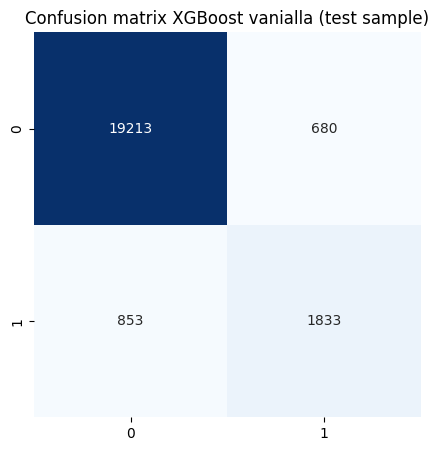

Predicted AUC: 95.633%, Gini coefficient: 91.266%
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     19893
           1       0.73      0.68      0.71      2686

    accuracy                           0.93     22579
   macro avg       0.84      0.82      0.83     22579
weighted avg       0.93      0.93      0.93     22579

[[19213   680]
 [  853  1833]]


In [9]:
c = 'XGBoost vanialla'
model_xgb = xgb.XGBClassifier(objective='binary:logistic'
                          ,booster='gbtree'
                          ,eval_metric='auc',
                          enable_categorical=True)

model_xgb.fit(X_train, y_train)

if SHOW_TEST_ONLY:
    general_model_metrics(model_xgb,y_test, X_test, f'{c} (test sample)')
    
else:
    general_model_metrics(model_xgb,y_test, X_test, f'{c} (test sample)')
    general_model_metrics(model_xgb, y_train, X_train, f'{c} (train sample)')
    general_model_metrics(model_xgb,y, X, f'{c} (total sample)')
    
# save the model to disk
model_xgb.save_model(f'{saved_models}/model_xgb.json')

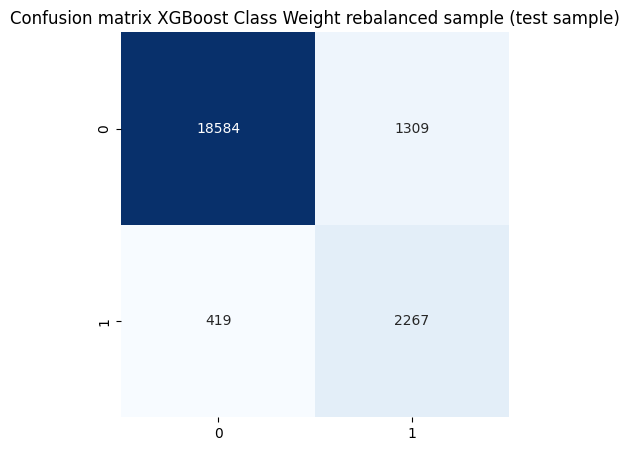

Predicted AUC: 95.694%, Gini coefficient: 91.388%
              precision    recall  f1-score   support

           0       0.98      0.93      0.96     19893
           1       0.63      0.84      0.72      2686

    accuracy                           0.92     22579
   macro avg       0.81      0.89      0.84     22579
weighted avg       0.94      0.92      0.93     22579

[[18584  1309]
 [  419  2267]]


In [10]:
c = 'XGBoost Class Weight rebalanced sample'
class_weights = compute_sample_weight('balanced', y=y_train)
model_reweighted = xgb.XGBClassifier(objective='binary:logistic'
                          ,booster='gbtree'
                          ,eval_metric='auc'
                          ,enable_categorical = True)

model_reweighted.fit(X_train, y_train, sample_weight=class_weights)

SHOW_TEST_ONLY = True

if SHOW_TEST_ONLY:
    general_model_metrics(model_reweighted,y_test, X_test, f'{c} (test sample)')
    
else:
    general_model_metrics(model_reweighted,y_test, X_test, f'{c} (test sample)')
    general_model_metrics(model_reweighted, y_train, X_train, f'{c} (train sample)')
    general_model_metrics(model_reweighted,y, X, f'{c} (total sample)')
    


In [19]:
from sklearn.model_selection import GridSearchCV

class_weights = compute_sample_weight('balanced', y=y_train)
model_xgb_gs = xgb.XGBClassifier(objective='binary:logistic'
                          ,booster='gbtree'
                          ,eval_metric='auc'
                          ,enable_categorical = True)

parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

grid_search = GridSearchCV(
    estimator=model_xgb_gs,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)
c = 'XGBoost grid search balanced sample'
grid_search.fit(X_train, y_train, sample_weight=class_weights)
general_model_metrics(grid_search.best_estimator_,y_test, X_test, f'{c} (test sample)')

Fitting 10 folds for each of 96 candidates, totalling 960 fits


In [4]:
# Load the model from disk
loaded_model = xgb.XGBClassifier(objective='binary:logistic'
                          ,booster='gbtree'
                          ,eval_metric='auc'
                          ,enable_categorical = True)
loaded_model.load_model(f'{saved_models}/model_xgb.json')

#### 5. The Gradient boosting tree is explained
With classic feature attributions we try out the global feature importance calcuations that come with XGBoost. Note that they all contradict each other, which motivates the use of SHAP values since they come with consistency gaurentees (meaning they will order the features correctly).

In [5]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(loaded_model)
shap_values = explainer.shap_values(X)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [6]:
# Take a look at the first observation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

In blue (negative Shap values) show that when these variables == # they have very high negative impact on the this observation (we are looking only at the first onservation) of the training dataset. While the Shap value in red (barely visible PredictedNameMatch) represents everything that helps to identify a match.

## Visualize many predictions
If we take many plot explanations such as the one shown above and transpose and stack them horizontally, we can see explanations for an entire dataset (in the notebook this plot is interactive):

In [10]:
shap.force_plot(explainer.expected_value, shap_values[:100,:], X_train.iloc[:100,:])

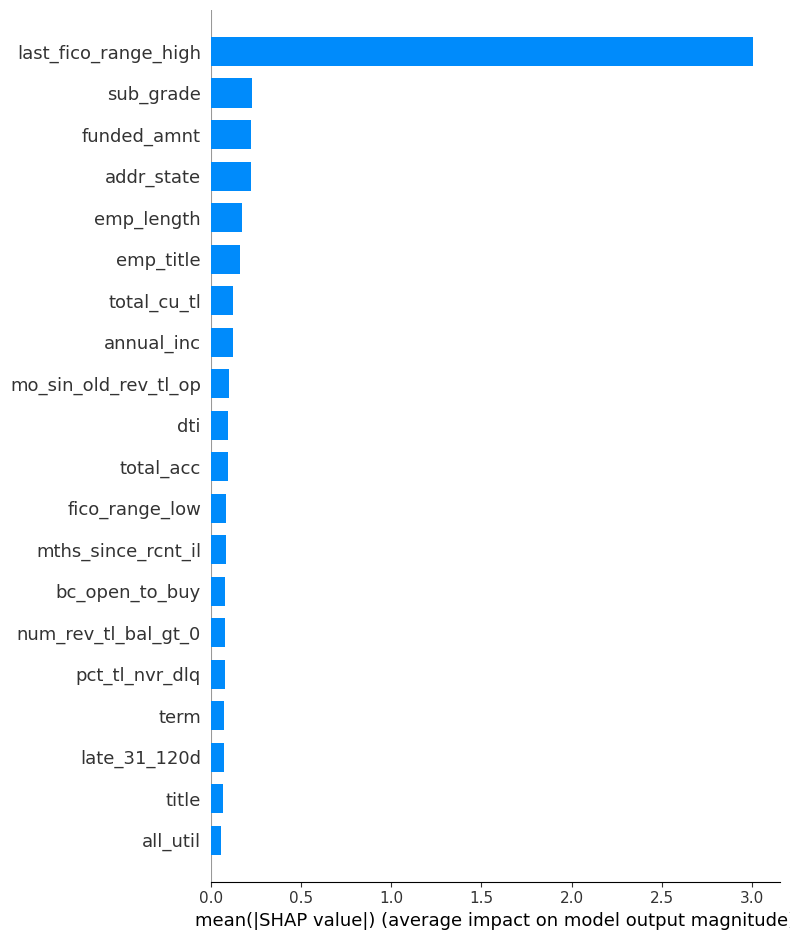

In [7]:
# plot the global importance of each feature
shap.summary_plot(shap_values, X_train, plot_type="bar")

Another representation could be the density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples.

In this case the independent features are more or less straightforward and intuitive. Date mapping match, when present has the highest postive impact on the final model predictions (except for a couple of outliers in Description match). On the other hand if DateMappingMatch = 0 the predictability drops. The graph below would be very interesting to see in cases of more complex non-linear variables.

Note that when the scatter points don’t fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.This summary plot replaces the typical bar chart of feature importance. It tells which features are most important, and also their range of effects over the dataset. The color allows us match how changes in the value of a feature effect the change in risk (e.g. past defaults and total active balance increase the log odds)

The summary plot combines feature importance with feature effects. Each point on the summary plot is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. The color represents the value of the feature from low to high. Overlapping points are jittered in y-axis direction, so we get a sense of the distribution of the Shapley values per feature. The features are ordered according to their importance.


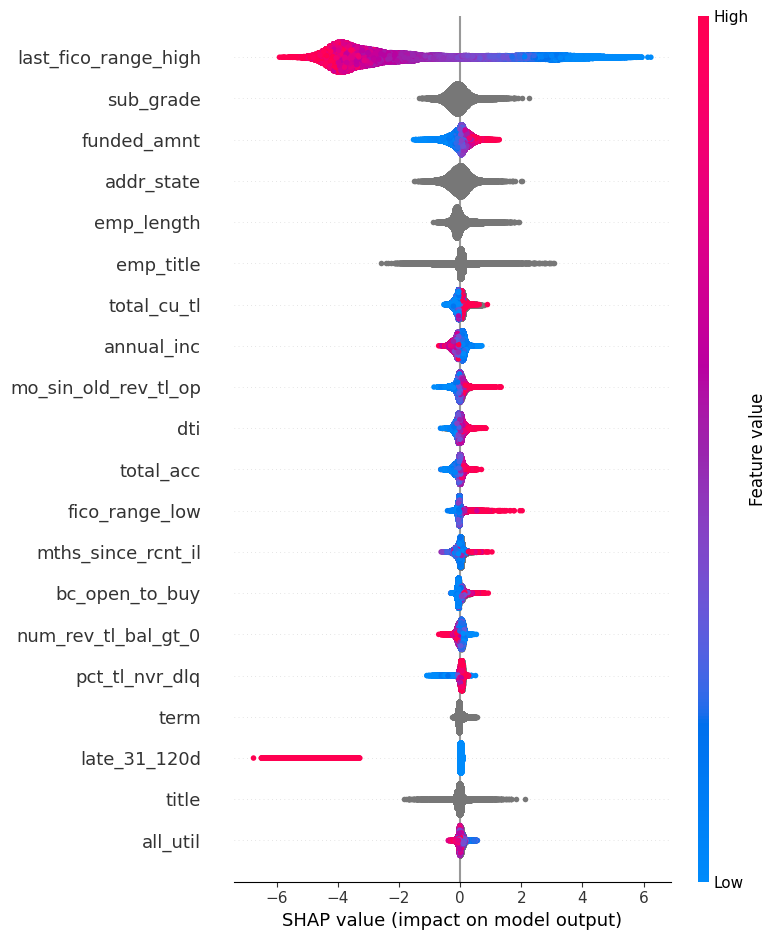

In [9]:
shap.summary_plot(shap_values, X)

Additional to try:
1. Optimization
2. Derive more variables - e.g. salary/amount, other percentages, derive more fields from dates
3. Separate models for different products (e.g. by term)
